In [1]:
import matplotlib.pyplot as plt
import numpy as np

import DissimilarityMetrics
import ChannelChartingCore
import Evaluation

2024-10-09 13:19:12.375146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 13:19:13.150965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# This may take some time
import dichasus_cf0x

2024-10-09 13:19:14.488096: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-09 13:19:14.537431: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-09 13:19:14.537817: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Remove CSI from all antenna arrays except array b=2
csi_time_domain_onearray = dichasus_cf0x.csi_time_domain[:,1][:,np.newaxis]

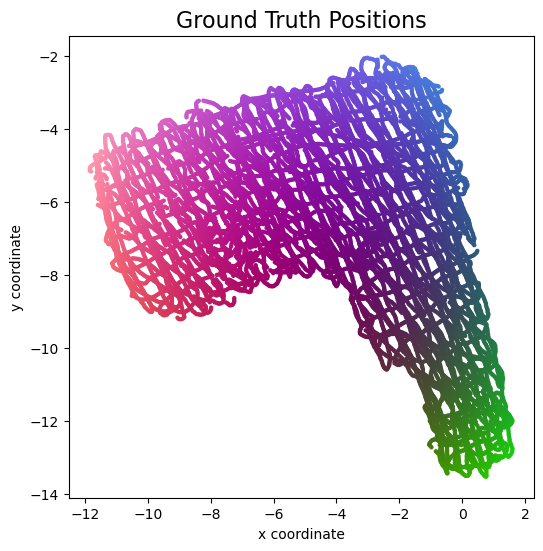

In [4]:
Evaluation.plot_colorized(dichasus_cf0x.groundtruth_positions, dichasus_cf0x.groundtruth_positions, title="Ground Truth Positions")

In [5]:
def mean_variance_from_delta_adp(delta_adp):
    mean = np.where(delta_adp < 1, 0,
           np.where(np.logical_and(delta_adp >= 1, delta_adp < 2), 0.01 * delta_adp + 0.01, 
           #np.where(np.logical_and(delta_adp >= 4, delta_adp < 5), 0.01 * delta_adp + 0.01,
           np.where(delta_adp > 2, np.inf, np.nan)))

    variance = np.where(delta_adp < 1, 0.0001,
       np.where(np.logical_and(delta_adp >= 1, delta_adp < 2), 0.0002 + 0.00005 * delta_adp, 
       #np.where(np.logical_and(delta_adp >= 4, delta_adp < 5), 0.0008,
       np.where(delta_adp > 2, 10000, np.nan)))

    return mean, variance

adp_metric = DissimilarityMetrics.ADPDissimilarityMetric(csi_time_domain_onearray, mean_variance_from_delta_adp)

In [6]:
velocity_mean = 0.235
velocity_variance = 0.007

# Make worste-case assumption of perfectly correlated velocities. This maximizes the variance.
velocity_metric = DissimilarityMetrics.VelocityDissimilarityMetric(velocity_mean, velocity_variance, True, dichasus_cf0x.timestamps)

In [7]:
GDM = ChannelChartingCore.GaussianDissimilarityModel([adp_metric, velocity_metric])
GDM.generate_short_paths(realization_count = 8)

  0%|          | 0/8 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


  0%|          | 0/104255000 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


  0%|          | 0/104255000 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


  0%|          | 0/104255000 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


  0%|          | 0/104255000 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


  0%|          | 0/104255000 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


  0%|          | 0/104255000 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


  0%|          | 0/104255000 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


  0%|          | 0/104255000 [00:00<?, ?it/s]

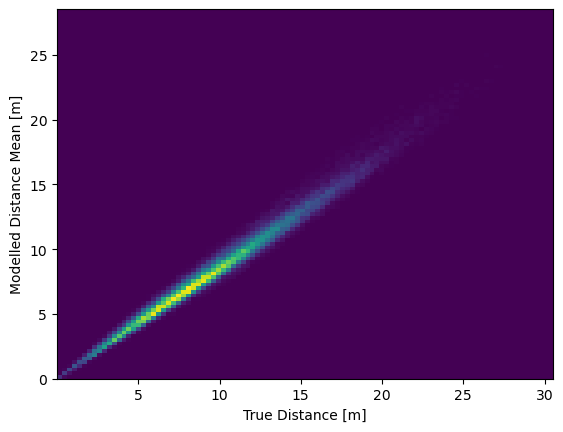

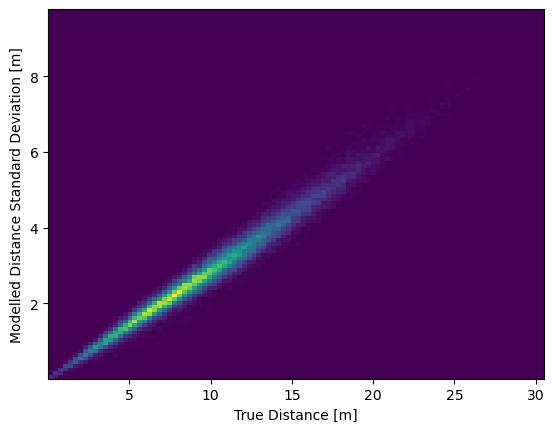

In [8]:
paths, path_hops, paths_d_mean, paths_d_variance = GDM.get_random_short_paths(50000, 100)
groundtruth_distance_matrix = np.sqrt(np.sum((dichasus_cf0x.groundtruth_positions[:,np.newaxis,:] - dichasus_cf0x.groundtruth_positions[np.newaxis,:,:])**2, axis = -1))
groundtruth_dist = np.sum(groundtruth_distance_matrix[paths[:,:-1], paths[:,1:]], axis = 1).flatten()

plt.xlabel("True Distance [m]")
plt.ylabel("Modelled Distance Mean [m]")
plt.hist2d(groundtruth_dist, paths_d_mean, bins = 100)
plt.show()

plt.xlabel("True Distance [m]")
plt.ylabel("Modelled Distance Standard Deviation [m]")
plt.hist2d(groundtruth_dist, np.sqrt(paths_d_variance), bins = 100)
plt.show()

In [9]:
BATCH_SIZE = 3000
LEARNING_RATE_INITIAL = 1e-2
LEARNING_RATE_FINAL = 1e-5
MIN_PATHHOPS = 5
MAX_PATHHOPS = 30
TRAINING_BATCHES = 2000

I0000 00:00:1728480320.001425   38094 service.cc:145] XLA service 0x7f2f601dc640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728480320.001482   38094 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-10-09 13:25:20.123117: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-09 13:25:20.428494: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-10-09 13:25:21.122044: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

tf.Tensor(0.01, shape=(), dtype=float32)
   1/2000 ━━━━━━━━━━━━━━━━━━━━ 3:03:55 6s/step - loss: 73.4367 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
tf.Tensor(0.01, shape=(), dtype=float32)
   3/2000 ━━━━━━━━━━━━━━━━━━━━ 2:04 62ms/step - loss: 71.8531 - metric: 0.0000e+00 tf.Tensor(0.01, shape=(), dtype=float32)
   4/2000 ━━━━━━━━━━━━━━━━━━━━ 3:01 91ms/step - loss: 68.4496 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
   5/2000 ━━━━━━━━━━━━━━━━━━━━ 3:12 97ms/step - loss: 64.7740 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
   6/2000 ━━━━━━━━━━━━━━━━━━━━ 3:23 102ms/step - loss: 61.3008 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
   7/2000 ━━━━━━━━━━━━━━━━━━━━ 3:31 106ms/step - loss: 58.1672 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
   8/2000 ━━━━━━━━━━━━━━━━━━━━ 3:33 107ms/step - loss: 55.3606 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
   9/2000 ━━━━━━━━━━━━━━━━━━━━ 3:37 109ms/step - los

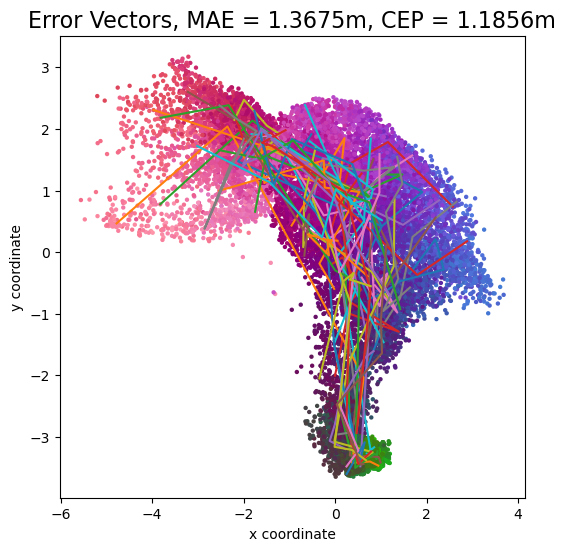

 200/2000 ━━━━━━━━━━━━━━━━━━━━ 3:35 119ms/step - loss: 13.2514 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
tf.Tensor(0.01, shape=(), dtype=float32)
 202/2000 ━━━━━━━━━━━━━━━━━━━━ 3:33 119ms/step - loss: 13.2009 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 203/2000 ━━━━━━━━━━━━━━━━━━━━ 3:33 119ms/step - loss: 13.1759 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 204/2000 ━━━━━━━━━━━━━━━━━━━━ 3:33 119ms/step - loss: 13.1512 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 205/2000 ━━━━━━━━━━━━━━━━━━━━ 3:32 119ms/step - loss: 13.1267 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 206/2000 ━━━━━━━━━━━━━━━━━━━━ 3:32 119ms/step - loss: 13.1023 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 207/2000 ━━━━━━━━━━━━━━━━━━━━ 3:32 119ms/step - loss: 13.0782 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 208/2000 ━━━━━━━━━━━━━━━━━━━━ 3:32 119ms/step - loss: 13.0542 - metric: 0.0000e+00tf.Tenso

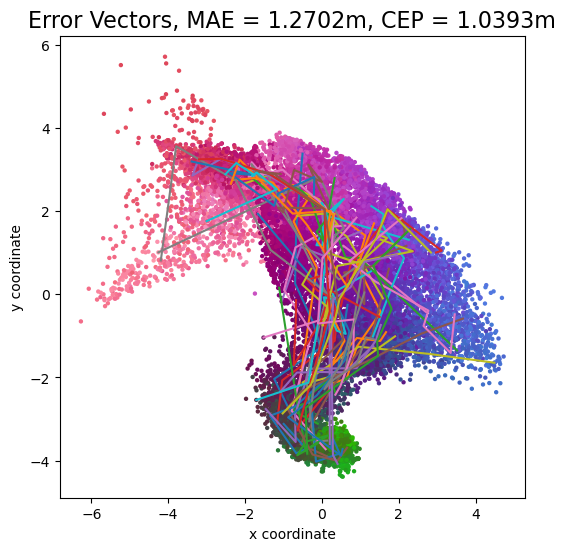

 400/2000 ━━━━━━━━━━━━━━━━━━━━ 3:07 117ms/step - loss: 10.2944 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
tf.Tensor(0.01, shape=(), dtype=float32)
tf.Tensor(0.01, shape=(), dtype=float32)
 403/2000 ━━━━━━━━━━━━━━━━━━━━ 3:06 117ms/step - loss: 10.2677 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 404/2000 ━━━━━━━━━━━━━━━━━━━━ 3:06 117ms/step - loss: 10.2589 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 405/2000 ━━━━━━━━━━━━━━━━━━━━ 3:06 117ms/step - loss: 10.2501 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 406/2000 ━━━━━━━━━━━━━━━━━━━━ 3:06 117ms/step - loss: 10.2413 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 407/2000 ━━━━━━━━━━━━━━━━━━━━ 3:06 117ms/step - loss: 10.2326 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 408/2000 ━━━━━━━━━━━━━━━━━━━━ 3:05 117ms/step - loss: 10.2238 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 409/2000 ━━━━━━━━━━━━━━━━━━━━ 3:05 117ms/step - l

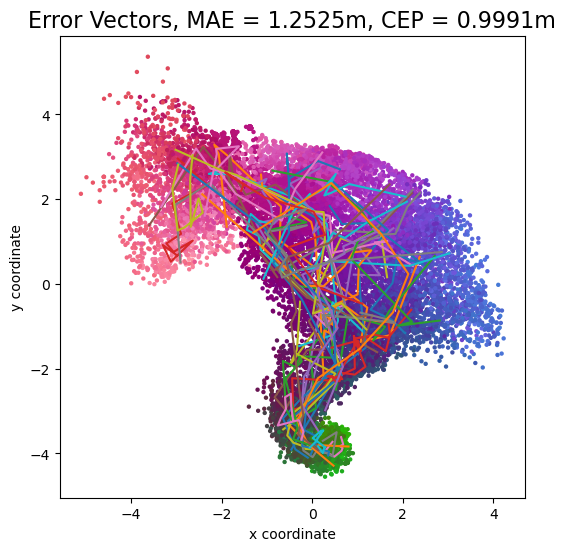

 600/2000 ━━━━━━━━━━━━━━━━━━━━ 2:43 117ms/step - loss: 8.9443 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
tf.Tensor(0.01, shape=(), dtype=float32)
 602/2000 ━━━━━━━━━━━━━━━━━━━━ 2:42 116ms/step - loss: 8.9339 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 603/2000 ━━━━━━━━━━━━━━━━━━━━ 2:42 116ms/step - loss: 8.9287 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 604/2000 ━━━━━━━━━━━━━━━━━━━━ 2:42 116ms/step - loss: 8.9235 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 605/2000 ━━━━━━━━━━━━━━━━━━━━ 2:42 116ms/step - loss: 8.9183 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 606/2000 ━━━━━━━━━━━━━━━━━━━━ 2:42 116ms/step - loss: 8.9132 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 607/2000 ━━━━━━━━━━━━━━━━━━━━ 2:42 116ms/step - loss: 8.9080 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 608/2000 ━━━━━━━━━━━━━━━━━━━━ 2:42 116ms/step - loss: 8.9029 - metric: 0.0000e+00tf.Tensor(0.01, 

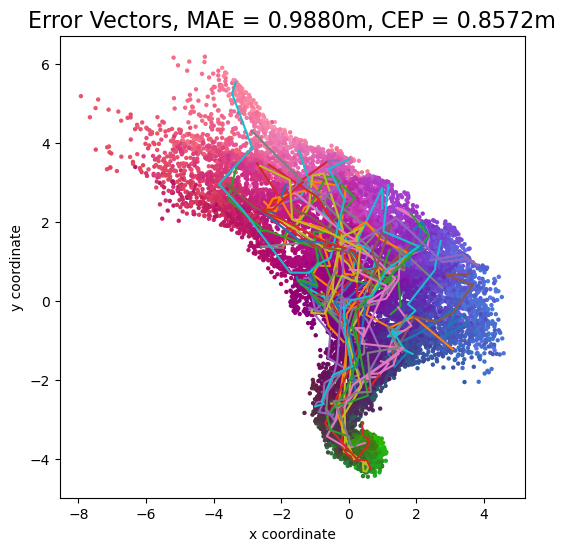

 800/2000 ━━━━━━━━━━━━━━━━━━━━ 2:20 117ms/step - loss: 8.0706 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
tf.Tensor(0.01, shape=(), dtype=float32)
 802/2000 ━━━━━━━━━━━━━━━━━━━━ 2:19 117ms/step - loss: 8.0632 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 803/2000 ━━━━━━━━━━━━━━━━━━━━ 2:19 117ms/step - loss: 8.0595 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 804/2000 ━━━━━━━━━━━━━━━━━━━━ 2:19 117ms/step - loss: 8.0558 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 805/2000 ━━━━━━━━━━━━━━━━━━━━ 2:19 117ms/step - loss: 8.0521 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 806/2000 ━━━━━━━━━━━━━━━━━━━━ 2:19 117ms/step - loss: 8.0484 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 807/2000 ━━━━━━━━━━━━━━━━━━━━ 2:19 117ms/step - loss: 8.0447 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
 808/2000 ━━━━━━━━━━━━━━━━━━━━ 2:19 117ms/step - loss: 8.0411 - metric: 0.0000e+00tf.Tensor(0.01, 

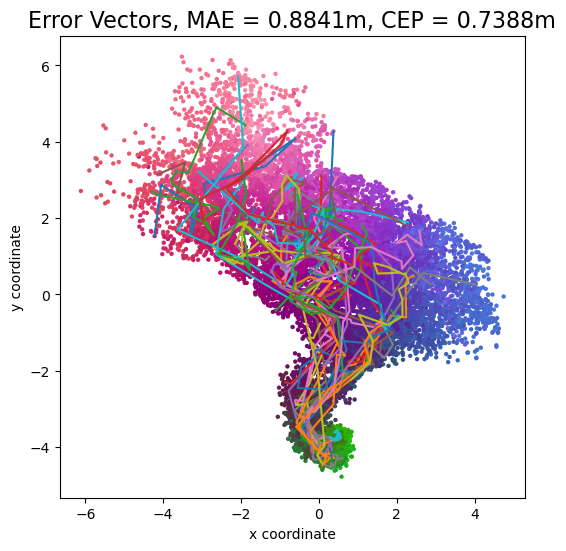

1000/2000 ━━━━━━━━━━━━━━━━━━━━ 1:57 117ms/step - loss: 7.4184 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
tf.Tensor(0.01, shape=(), dtype=float32)
1002/2000 ━━━━━━━━━━━━━━━━━━━━ 1:56 117ms/step - loss: 7.4126 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1003/2000 ━━━━━━━━━━━━━━━━━━━━ 1:56 117ms/step - loss: 7.4098 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1004/2000 ━━━━━━━━━━━━━━━━━━━━ 1:56 117ms/step - loss: 7.4069 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1005/2000 ━━━━━━━━━━━━━━━━━━━━ 1:56 117ms/step - loss: 7.4040 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1006/2000 ━━━━━━━━━━━━━━━━━━━━ 1:56 117ms/step - loss: 7.4012 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1007/2000 ━━━━━━━━━━━━━━━━━━━━ 1:56 117ms/step - loss: 7.3983 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1008/2000 ━━━━━━━━━━━━━━━━━━━━ 1:56 117ms/step - loss: 7.3955 - metric: 0.0000e+00tf.Tensor(0.01, 

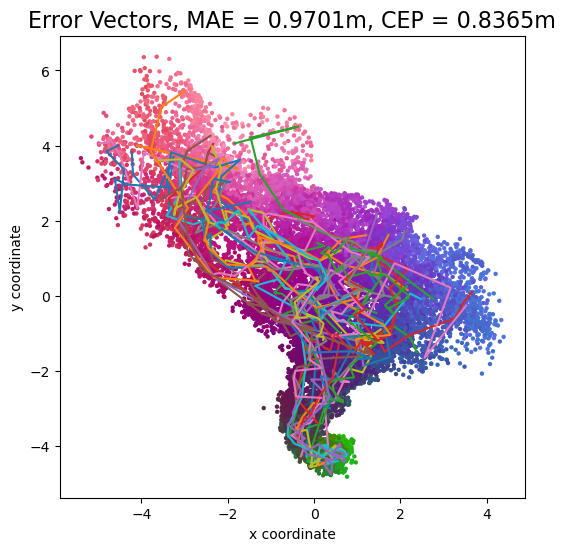

1200/2000 ━━━━━━━━━━━━━━━━━━━━ 1:34 118ms/step - loss: 6.8994 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
tf.Tensor(0.01, shape=(), dtype=float32)
1202/2000 ━━━━━━━━━━━━━━━━━━━━ 1:33 118ms/step - loss: 6.8947 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1203/2000 ━━━━━━━━━━━━━━━━━━━━ 1:33 118ms/step - loss: 6.8924 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1204/2000 ━━━━━━━━━━━━━━━━━━━━ 1:33 118ms/step - loss: 6.8900 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1205/2000 ━━━━━━━━━━━━━━━━━━━━ 1:33 118ms/step - loss: 6.8877 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1206/2000 ━━━━━━━━━━━━━━━━━━━━ 1:33 118ms/step - loss: 6.8854 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1207/2000 ━━━━━━━━━━━━━━━━━━━━ 1:33 118ms/step - loss: 6.8831 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1208/2000 ━━━━━━━━━━━━━━━━━━━━ 1:33 118ms/step - loss: 6.8807 - metric: 0.0000e+00tf.Tensor(0.01, 

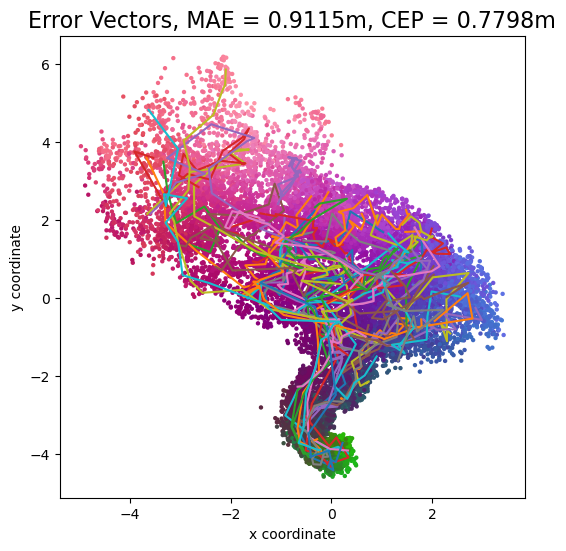

1400/2000 ━━━━━━━━━━━━━━━━━━━━ 1:10 118ms/step - loss: 6.4718 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
tf.Tensor(0.01, shape=(), dtype=float32)
1402/2000 ━━━━━━━━━━━━━━━━━━━━ 1:10 118ms/step - loss: 6.4679 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1403/2000 ━━━━━━━━━━━━━━━━━━━━ 1:10 118ms/step - loss: 6.4659 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1404/2000 ━━━━━━━━━━━━━━━━━━━━ 1:10 118ms/step - loss: 6.4640 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1405/2000 ━━━━━━━━━━━━━━━━━━━━ 1:10 118ms/step - loss: 6.4620 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1406/2000 ━━━━━━━━━━━━━━━━━━━━ 1:09 118ms/step - loss: 6.4601 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1407/2000 ━━━━━━━━━━━━━━━━━━━━ 1:09 118ms/step - loss: 6.4581 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1408/2000 ━━━━━━━━━━━━━━━━━━━━ 1:09 118ms/step - loss: 6.4562 - metric: 0.0000e+00tf.Tensor(0.01, 

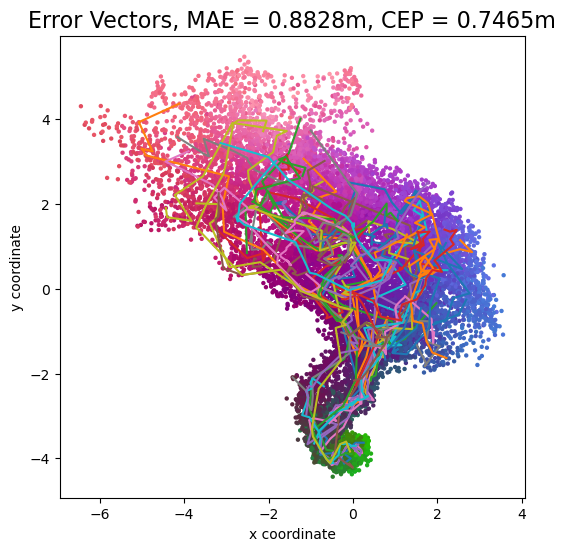

1600/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 118ms/step - loss: 6.1111 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
tf.Tensor(0.01, shape=(), dtype=float32)
1602/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 118ms/step - loss: 6.1078 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1603/2000 ━━━━━━━━━━━━━━━━━━━━ 46s 118ms/step - loss: 6.1061 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1604/2000 ━━━━━━━━━━━━━━━━━━━━ 46s 118ms/step - loss: 6.1045 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1605/2000 ━━━━━━━━━━━━━━━━━━━━ 46s 118ms/step - loss: 6.1028 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1606/2000 ━━━━━━━━━━━━━━━━━━━━ 46s 118ms/step - loss: 6.1012 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1607/2000 ━━━━━━━━━━━━━━━━━━━━ 46s 118ms/step - loss: 6.0995 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1608/2000 ━━━━━━━━━━━━━━━━━━━━ 46s 118ms/step - loss: 6.0978 - metric: 0.0000e+00tf.Tensor(0.01, shape=()

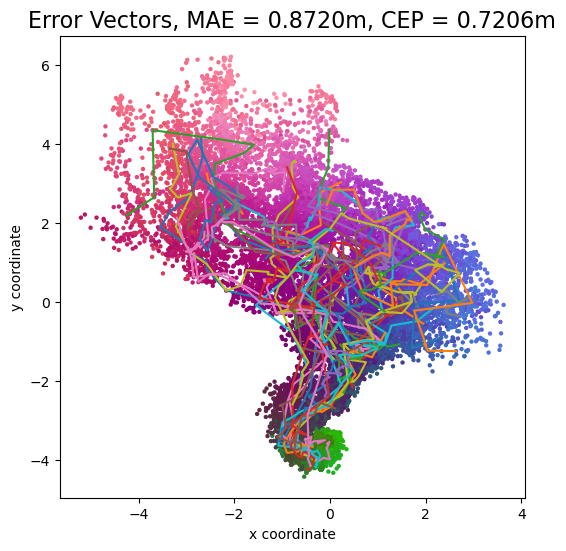

1800/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - loss: 5.8006 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
tf.Tensor(0.01, shape=(), dtype=float32)
1802/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - loss: 5.7978 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1803/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - loss: 5.7963 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1804/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - loss: 5.7949 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1805/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - loss: 5.7934 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1806/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - loss: 5.7920 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1807/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - loss: 5.7905 - metric: 0.0000e+00tf.Tensor(0.01, shape=(), dtype=float32)
1808/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - loss: 5.7891 - metric: 0.0000e+00tf.Tensor(0.01, shape=()

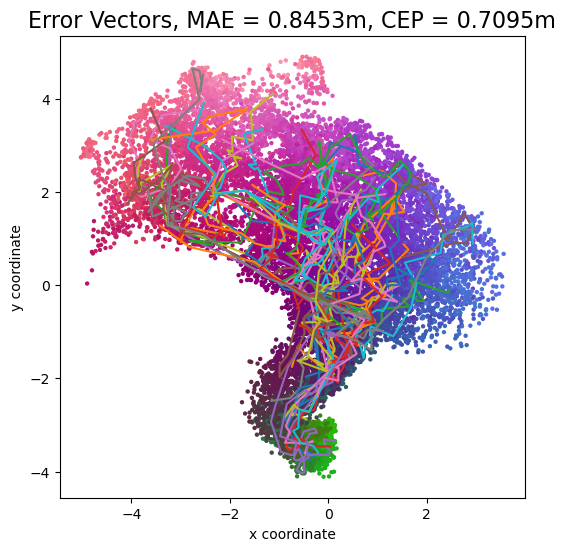

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 244s 119ms/step - loss: 5.5280 - metric: 0.0000e+00


In [10]:
plot_callback = Evaluation.PlotChartCallback(dichasus_cf0x.groundtruth_positions, csi_time_domain_onearray.shape[0], BATCH_SIZE, MAX_PATHHOPS)
cc = ChannelChartingCore.ChannelChart(GDM, csi_time_domain_onearray, dichasus_cf0x.timestamps, batch_size = BATCH_SIZE, learning_rate_initial = LEARNING_RATE_INITIAL, learning_rate_final = LEARNING_RATE_FINAL, min_pathhops = MIN_PATHHOPS, max_pathhops = MAX_PATHHOPS, training_batches = TRAINING_BATCHES, plot_callback = plot_callback)

In [11]:
channel_chart_positions = cc.predict(csi_time_domain_onearray)

652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [12]:
ct, tw, ks = Evaluation.ct_tw_ks_on_subset(dichasus_cf0x.groundtruth_positions, channel_chart_positions)
print(f"CT: {ct:.4f}\nTW: {tw:.4f}\nKS: {ks:.4f}")

CT: 0.9838
TW: 0.9828
KS: 0.1640


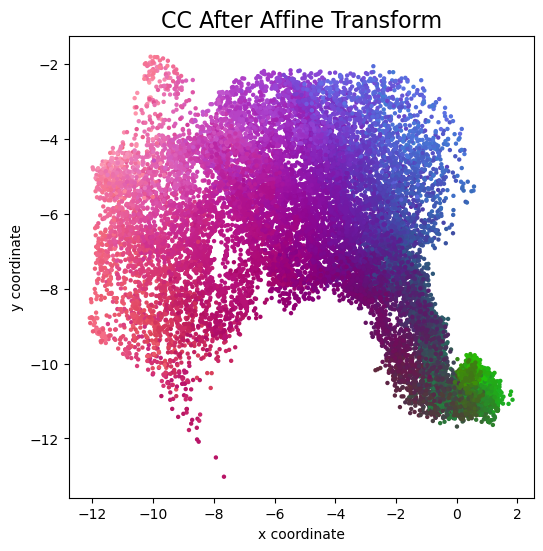

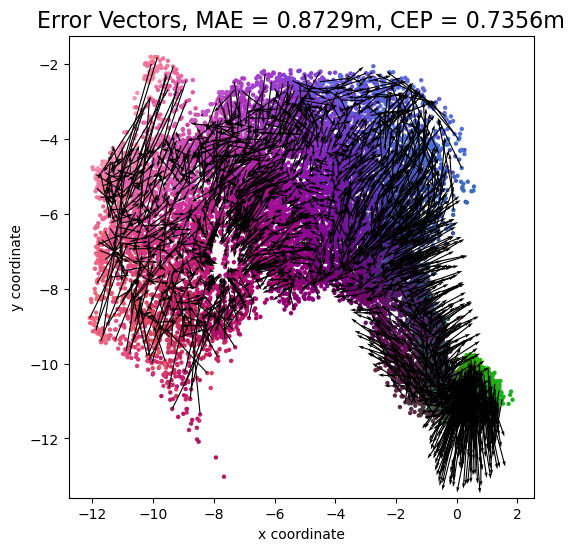

In [13]:
channel_chart_positions_transformed, errorvectors, errors, mae, cep = Evaluation.mean_absolute_error_transformed(dichasus_cf0x.groundtruth_positions, channel_chart_positions)
Evaluation.plot_colorized(channel_chart_positions_transformed, dichasus_cf0x.groundtruth_positions, title = "CC After Affine Transform")

nth_errorvector = 10
Evaluation.plot_colorized(channel_chart_positions_transformed, dichasus_cf0x.groundtruth_positions, title = f"Error Vectors, MAE = {mae:.4f}m, CEP = {cep:.4f}m", show = False)
plt.quiver(channel_chart_positions_transformed[::nth_errorvector, 0], channel_chart_positions_transformed[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.show()